###### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

###### read csv

In [2]:
df_ratings = pd.read_csv('BX-Book-Ratings.csv', encoding='latin1', delimiter=';')
print('\lenght: ',len(df_ratings))
total_ratings = len(df_ratings)
df_ratings.head().sort_values(by='Book-Rating',ascending=True)

\lenght:  1149780


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
2,276727,0446520802,0
3,276729,052165615X,3
1,276726,0155061224,5
4,276729,0521795028,6


# Group by User-ID

In [3]:
ratings_u = df_ratings.groupby('User-ID').count().sort_values(by='ISBN',ascending=False)
ratings_u.head()

,ISBN,Book-Rating
User-ID,,
11676,13602,13602
198711,7550,7550
153662,6109,6109
98391,5891,5891
35859,5850,5850


###### This is total ratings per user in a histogram. Users with more than 4.000 ratings are considered outliers,
###### as well as users with only one rate
###### This values will be removed using z-score at the beginning (for users with extreme number of ratings) 
###### and  manually the users with one rating only

<AxesSubplot:title={'center':'Number of Ratings per user in log scale before cleaning'}, xlabel='number of ratings', ylabel='number of users'>

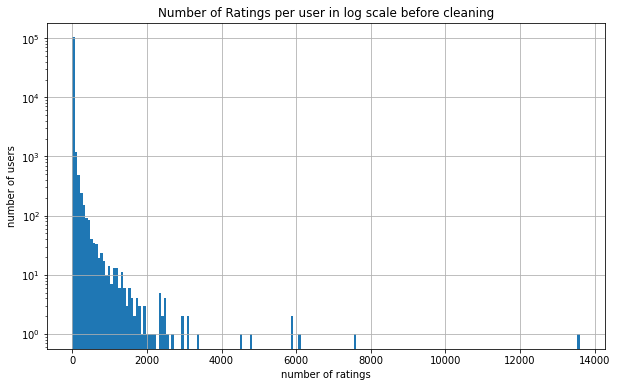

In [21]:
graph = ratings_u[(ratings_u['ISBN']>= 0) & (ratings_u['ISBN']<=20000) ]['ISBN'].hist(bins = 200,figsize = (10,6),legend=False,log=True)
graph.set_xlabel("number of ratings")
graph.set_ylabel('number of users')
graph.set_title('Number of Ratings per user in log scale before cleaning')
graph

###### and one more plot with log scale with out outliers

<AxesSubplot:title={'center':'Number of Ratings per user in log scale after cleaning'}, xlabel='number of books', ylabel='number of ratings'>

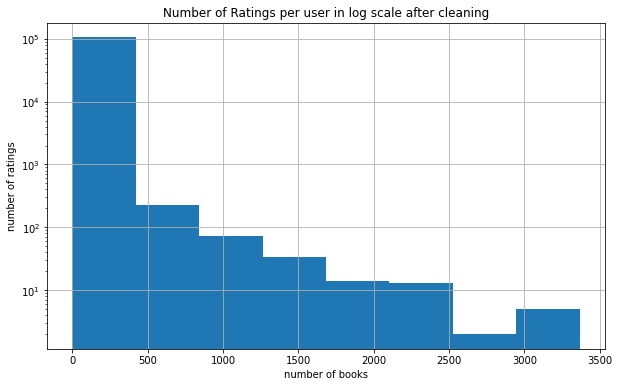

In [5]:
graph = ratings_u[(ratings_u['ISBN']>= 0) & (ratings_u['ISBN']<=4000) ]['ISBN'].hist(bins = 8,figsize = (10,6),legend=False,log=True)
graph.set_xlabel("number of books")
graph.set_ylabel('number of ratings')
graph.set_title('Number of Ratings per user in log scale after cleaning')
graph

###### find mean, stdev and assing threshold

In [6]:
mean = np.mean(ratings_u['ISBN'])
print('mean = ',mean)
s = np.std(ratings_u['ISBN'])
print('st_dev = ',s)
threshold = 4

mean =  10.920851419507423
st_dev =  90.56239509385493


###### Turn Values to Z values

In [7]:
ratings_u['z'] = (ratings_u['ISBN']-mean)/s
print(len(ratings_u[ratings_u['z'] > threshold]),""" users have extreme number of ratings and will be removed """)

439  users have extreme number of ratings and will be removed 


###### Create temporary table with zscore
and drop users with zscore<threshold 
and users with 1 rating

In [8]:
#drop outliers based on st_dev
tempdf = ratings_u[ratings_u['z'] < threshold].sort_values(by='ISBN',ascending=True)
#drop outliers with rating < 1
tempdf = tempdf[tempdf['ISBN']>=2]
tempdf.head()

,ISBN,Book-Rating,z
User-ID,,,
21407,2,2,-0.098505
146759,2,2,-0.098505
170496,2,2,-0.098505
134415,2,2,-0.098505
21402,2,2,-0.098505


###### here is how it look now

<AxesSubplot:title={'center':'Number of Ratings per user in log scale after cleaning'}, xlabel='number of ratings', ylabel='number of users'>

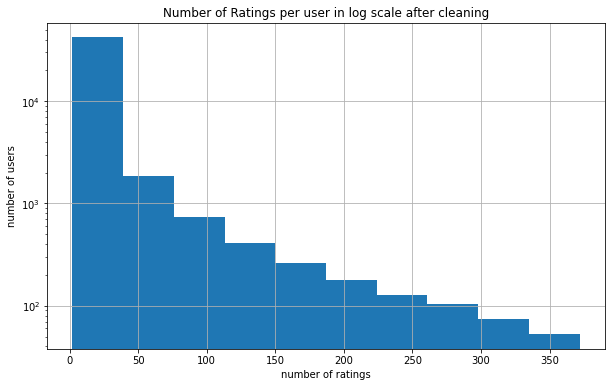

In [9]:
graph  = tempdf['ISBN'].hist(bins = 10,log=True,figsize = (10,6))
graph.set_xlabel("number of ratings")
graph.set_ylabel('number of users')
graph.set_title('Number of Ratings per user in log scale after cleaning')
graph

###### Keep in the main table only users that also belong in temporary table with zscore

In [10]:
df_ratings_clean = df_ratings[df_ratings['User-ID'].isin(tempdf.index)].sort_values(by='Book-Rating',ascending=False)
df_ratings_clean.head()

,User-ID,ISBN,Book-Rating
811777,197477,8886881002,10
758642,183436,1569318697,10
758344,183287,2844050328,10
91388,20265,0440998050,10
758345,183287,2844050441,10


# Group by ISBN
######  and drop ISBN's with only one rating

In [11]:
foo = df_ratings_clean.groupby(by='ISBN').count().sort_values(by='User-ID',ascending=True)
foo = foo[foo['User-ID']>1]
foo.head()

,User-ID,Book-Rating
ISBN,,
2070518019,2,2
0312966369,2,2
038070563X,2,2
0373223919,2,2
1400031184,2,2


In [12]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['ISBN'].isin(foo.index)]
df_ratings_clean = df_ratings_clean.sort_values('ISBN',ascending=True)
df_ratings_clean.head()

,User-ID,ISBN,Book-Rating
750718,181817,0330299891,6
371986,89192,0330299891,0
651696,157799,*0452281903,0
281376,66942,*0452281903,0
375081,90148,0 7515 0976 0,0


# Finally check invalid ISBN in the table

##### More than 10 characters ISBN

In [13]:
df_ratings_clean[df_ratings_clean['ISBN'].apply(len)>10]

,User-ID,ISBN,Book-Rating
750718,181817,0330299891,6
371986,89192,0330299891,0
651696,157799,*0452281903,0
281376,66942,*0452281903,0
375081,90148,0 7515 0976 0,0
...,...,...,...
286077,68436,SBN425037452,0
1140045,274117,ZR903CX0003,0
911826,222073,ZR903CX0003,0
793069,191707,`3502103682,0


###### Attempt to fix them by removing punctuations

In [14]:
df_ratings_clean['ISBN'].astype(str)
df_ratings_clean["ISBN"] = df_ratings_clean['ISBN'].str.replace(r'[^\w\d]','')

In [15]:
df_ratings_clean[df_ratings_clean['ISBN'].apply(len)>10]

,User-ID,ISBN,Book-Rating
299928,71285,00000000000,0
34259,8094,00000000000,0
59327,11795,00000000000,0
450174,107899,000000000000,0
215370,50321,000000000000,0
...,...,...,...
72936,15418,Narraciones,7
498768,120449,SBN425037452,0
286077,68436,SBN425037452,0
1140045,274117,ZR903CX0003,0


###### those isbn that left are not valid and have to be removed as well as values with les than 10 characters

In [16]:
df_ratings_clean[df_ratings_clean['ISBN'].apply(len)<10]

,User-ID,ISBN,Book-Rating
59324,11795,00000000,7
299925,71285,00000000,0
901310,218187,00000000,9
889176,214319,00000000,0
1145678,275650,00000000,0
...,...,...,...
571413,137348,M79702002,0
741756,179624,M79702002,0
34305,8094,M79702002,5
435262,104168,NOTGIVEN,7


##### So the table will only have the ISBN that len equals 10

In [17]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['ISBN'].apply(len)==10]
df_ratings_clean.sort_values('ISBN')

,User-ID,ISBN,Book-Rating
571367,137348,0000000000,0
299927,71285,0000000000,7
34258,8094,0000000000,10
59326,11795,0000000000,7
1145679,275650,0000000000,0
...,...,...,...
347593,82926,O786001690,0
694560,169321,O971880107,0
754827,182642,O971880107,0
562514,135172,XXXXXXXXXX,0


###### ISBN does not start with letters so they will be dropped out too

In [18]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['ISBN'].str.contains(r'(^[a-zA-Z])')==False]

c:\users\panos\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


###### and ISBN with number 0000000000 is not a valid ISBN so it will be dropped

In [19]:
df_ratings_clean=df_ratings_clean[df_ratings_clean['ISBN']!='0000000000']

In [20]:
df_ratings_clean = df_ratings_clean.groupby('ISBN')
graph = df_ratings_clean[df_ratings_clean['ISBN']>= '0']['ISBN'].hist(bins = 8,figsize = (10,6),legend=False,log=True)
graph.set_xlabel("number of books")
graph.set_ylabel('number of ratings')
graph.set_title('Number of Ratings for each book in log scale after cleaning')
graph

TypeError: '>=' not supported between instances of 'SeriesGroupBy' and 'str'

# Notes & TODO

In [ ]:
books_group = df_ratings_clean.groupby('Book-Rating').count()
books_group


In [ ]:
# still have of the sample has been rated as 0 (is that a book that should not be included in our reccomendation system?)

# graph with rating 0

In [ ]:
books_group['ISBN'].plot.bar()

# graph with rating > 0

In [ ]:
foo = books_group.drop(index=0)
foo['ISBN'].plot.bar()

In [ ]:
print('Books with rating = 0 :',len(df_ratings_clean[df_ratings_clean['Book-Rating']==0]))
print('Books with rating > 0 :',len(df_ratings_clean[df_ratings_clean['Book-Rating']!=0]),'more than 0')

if 0 is dropped then the table will be left with 

In [ ]:
len(df_ratings_clean)-len(df_ratings_clean[df_ratings_clean['Book-Rating']==0])

# Save the clean dataframe to a csv to be used for the rest of the project

In [ ]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['Book-Rating']>0]

In [ ]:
df_ratings_clean.to_csv('df_ratings_clean.csv')